<a href="https://colab.research.google.com/github/madonnaojorin/MAT494/blob/main/4.1_Network_Analysis_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##4.1.1 Graph Models

##4.1.2 Laplacian Matrix

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [27]:
data_dir = os.path.expanduser("/content/drive/My Drive/data")

In [29]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"
edgelist.sample(frac=1).head(5)

,target,source,label
362,1246,1104007,cites
2144,18313,249421,cites
266,887,334153,cites
3963,103515,246618,cites
1822,12210,57948,cites


In [30]:
cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx = nx.read_edgelist(path=cora_location)
cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)

In [21]:
node_attr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
0,31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Case_Based


In [31]:
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx, values, 'subject')
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)
g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
g_nx = max(g_nx_ccs, key=len)
node_ids = list(g_nx.nodes())
print("Largest subgraph statistics: {} nodes, {} edges".format(g_nx.number_of_nodes(), g_nx.number_of_edges()))
node_targets = [ g_nx.nodes[node_id]['subject'] 
                for node_id in node_ids]
print(f"There are {len(np.unique(node_targets))} unique labels on the nodes.")
print(f"There are {len(g_nx.nodes())} nodes in the network.")

Largest subgraph statistics: 2485 nodes, 5069 edges
There are 7 unique labels on the nodes.
There are 2485 nodes in the network.


In [32]:
colors = {'Case_Based': 'black',
              'Genetic_Algorithms': 'red',
              'Neural_Networks': 'blue',
              'Probabilistic_Methods': 'green',
              'Reinforcement_Learning': 'aqua',
              'Rule_Learning': 'purple',
              'Theory': 'yellow'}

####Unormalised graph Laplacian

In [33]:
# The adjacency matrix of the graph in numpy format:
A = nx.to_numpy_array(g_nx)

In [34]:
# The degree matrix from this:
D = np.diag(A.sum(axis=1))
print(D)

[[168.   0.   0. ...   0.   0.   0.]
 [  0.   5.   0. ...   0.   0.   0.]
 [  0.   0.   6. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   4.   0.   0.]
 [  0.   0.   0. ...   0.   4.   0.]
 [  0.   0.   0. ...   0.   0.   2.]]


In [35]:
# The unnormalized Laplacian:
L = D-A
print(L)

[[168.  -1.  -1. ...   0.   0.   0.]
 [ -1.   5.   0. ...   0.   0.   0.]
 [ -1.   0.   6. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   4.  -1.  -1.]
 [  0.   0.   0. ...  -1.   4.   0.]
 [  0.   0.   0. ...  -1.   0.   2.]]


#### Eigenvectors and eigenvalues of the Laplacian

In [36]:
eigenvalues, eigenvectors = np.linalg.eig(L)

In [37]:
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

In [38]:
order = np.argsort(eigenvalues)
eigenvalues = eigenvalues[order]

In [48]:
# Take a 32-dimensional subspace of the full vector space:
embedding_size = 32
v_0 = eigenvectors[:, order[0]]
v = eigenvectors[:, order[1:(embedding_size+1)]]

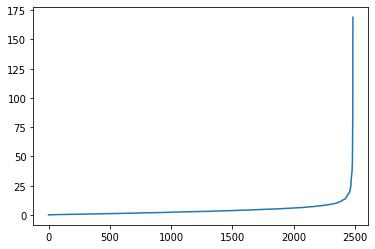

In [41]:
plt.plot(eigenvalues)

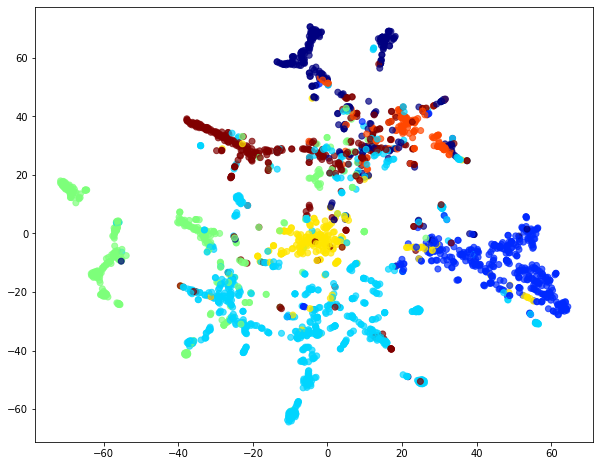

In [42]:
# Use t-SNE to visualize out 32-dimensional organization:
tsne = TSNE()
v_pr = tsne.fit_transform(v)
alpha=0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
fig = plt.figure(figsize=(10,8))
plt.scatter(v_pr[:,0], v_pr[:,1], c=node_colours, cmap="jet", alpha=alpha)

#### Training a classifier

In [47]:
X = v
Y = np.array(node_targets)
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=4)
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=140, random_state=42)
clf.fit(X_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.8785714285714286
score on X_test 0.71727078891258
